In [1]:
# Imports.
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import params as yamnet_params
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers 
import yamnet as yamnet_model
import params as yamnet_params
import features as features_lib
import pandas as pd
# Set random seed for TensorFlow
tf.random.set_seed(42)
np.random.seed(42)

2025-05-22 09:17:50.049089: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 09:17:50.094588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 09:17:50.738266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import params as yamnet_params
import features as features_lib
import yamnet as yamnet_model
sr = 10000
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
yamnet=yamnet_model.yamnet_frames_model(params)
class_names = yamnet_model.class_names('yamnet_class_map_1.csv')

(None,)


In [4]:
#load fine-trained weights 
import tensorflow as tf
try:
    yamnet.load_weights('yamnet_ndata.h5', by_name=True)
except Exception as e:
    print(f"Error loading weights: {e}")

In [39]:
import os
import numpy as np
import scipy.io.wavfile as wav
from scipy import signal
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.utils import to_categorical
from scipy.signal import spectrogram
import scipy.io.wavfile as wav
from scipy import signal

# Audio Feature Extraction
fs = 10000  # Known sample rate of the data set
segment_duration = 1
frame_duration = 0.025
hop_duration = 0.010
fft_size=512
segment_samples = int(segment_duration * fs)
frame_samples = int(frame_duration * fs)
hop_samples = int(hop_duration * fs)
min_frequency = 0
max_frequency = 2000

# Normalization
un_norm = 2 / (np.sum(signal.windows.hann(frame_samples, sym=False))**2)

def extract_features(file):
    sample_rate, y = wav.read(file)
    y_norm = np.int16(y / np.max(np.abs(y)) * 32767)
    f, t, Zxx = spectrogram(y_norm, fs=fs, nperseg=frame_samples, noverlap=frame_samples-hop_samples,nfft = 512)
    freq_mask = (f >= min_frequency) & (f <= max_frequency)
    linear_spectrum = Zxx.astype(float) 
    linear_spectrum = linear_spectrum[freq_mask, : ]
    linear_spectrum /= un_norm
    epsil=1e-6
    linear_spectrum = np.log10(linear_spectrum + epsil)
    return linear_spectrum[..., np.newaxis]

In [40]:
a = yamnet.predict(extract_features('/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_50.wav')[np.newaxis, ...])
prob = a / np.sum(a)
prob,np.argmax(prob, axis=1)[0]

1/1 [==============================] - 0s 38ms/step


(array([[0.28189537, 0.3447148 , 0.3733898 ]], dtype=float32), 2)

Gradcam

In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs, 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        # Ensure img_array is a Tensor and enable gradients
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
        tape.watch(img_array)
        # Get the outputs of the last convolutional layer and the model's predictions
        last_conv_layer_output, preds_output = grad_model(img_array)
        # Get the predicted class index
        pred_index = tf.argmax(preds_output[0])
        # Ensure the output of the predictions is used for gradient calculation
        class_channel = preds_output[0][pred_index]
        class_channel = tf.convert_to_tensor([class_channel])
        # Calculate the gradients of the class output with respect to the feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)
    # Pool the gradients across all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Access the values of the last conv layer output and the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    pooled_grads = tf.keras.backend.eval(pooled_grads)
    # Multiply the pooled gradients with the feature map output
    heatmap = tf.reduce_mean(tf.multiply(last_conv_layer_output, pooled_grads), axis=-1)
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap = resize(heatmap, (103,98), anti_aliasing=True)
    return heatmap

def set_axis_ticks(ax,i):
    # Set x-axis ticks based on the original range (0 to 36)
    ax.spines['left'].set_color('fuchsia')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('Brown')
    ax.spines['bottom'].set_linewidth(2)
    ax.set_xticks([0, 98])  
    ax.set_xticklabels(['0',  '1'],fontsize=12,color='Brown')  

    ax.set_yticks([0, 51, 103])  
    ax.set_yticklabels(['0', '1', '2'],fontsize=12,color='fuchsia')  
    ax.tick_params(axis='x', direction='in', length=4, width=1)  
    ax.tick_params(axis='y', direction='in', length=4, width=1,) 
    if  i == 0:
        ax.set_xlabel(r'$\mathit{t}$ (s)', fontsize=14, labelpad=0,color='Brown')
        ax.set_ylabel(r'$\mathit{f}$ (KHz)', fontsize=14,color='fuchsia')

def get_spectrogram(file):
    sample_rate, y = wav.read(file)
    f, t, Zxx = spectrogram(y, fs=sample_rate,nperseg=frame_samples, noverlap=frame_samples - hop_samples,nfft = 512)
    freq_mask = (f >= 0) & (f <= 2000)
    linear_spectrum = Zxx.astype(float)
    linear_spectrum = linear_spectrum[freq_mask, :]  
    linear_spectrum = 10 * np.log10(linear_spectrum + 1e-6)
    print(linear_spectrum.shape)
    return t, f[freq_mask], linear_spectrum

In [21]:
files = ["/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_50.wav",
         "/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2000.wav",
         "/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2587.wav"]

In [35]:
a = yamnet.predict(extract_features(files[0])[np.newaxis, ...])
prob = a / np.sum(a)
prob,np.argmax(prob, axis=1)[0]

1/1 [==============================] - 0s 47ms/step


(array([[0.22537926, 0.4082472 , 0.3663736 ]], dtype=float32), 1)

['/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_50.wav', '/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2000.wav', '/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2587.wav']
(103, 98)
1/1 [==============================] - 0s 42ms/step
[[0.22537926 0.4082472  0.3663736 ]]
Predicted Class: ('NB', 0.4082472)
['/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_50.wav', '/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2000.wav', '/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_2587.wav']
(103, 98)
1/1 [==============================] - 0s 43ms/step
[[0.22537926 0.4082472  0.3663736 ]]
Predicted Class: ('NB', 0.4082472)
['/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH_norm/Segment_50.wav', '/DATA/Suriya/Data/Nishant_dataset/Suriya/Transient Experiment Data/RH

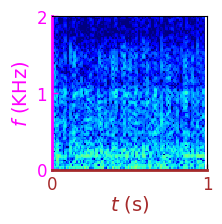

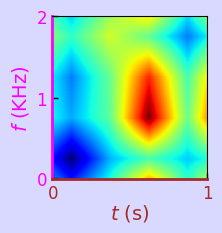

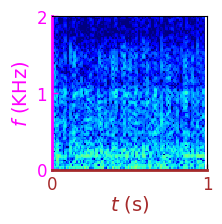

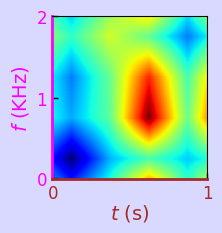

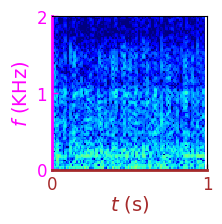

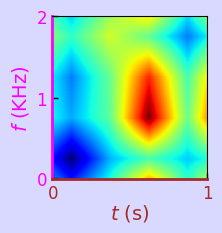

In [38]:
import warnings
import matplotlib.colors as mcolors

# files = ["",
#          "",
#          ""]
# Suppress all warnings
warnings.filterwarnings("ignore")
last_conv_layer_name = "layer14/pointwise_conv"
heatmaps = []
 
# Plot Spectrograms
labels = ['BKG','NB','TB']
for label in labels[:]:
    print(files)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (2,2))
    for i, file in enumerate(files[:1]):
        t, f, linear_spectrum=get_spectrogram(file)
        c = axs.pcolormesh(t, f, linear_spectrum, cmap='jet' ,vmin =-25, vmax=50)
        axs.set_yticks([0, 1000, 2000])  # Ticks in Hz
        axs.set_yticklabels([0,  1, 2], fontsize=12,color='fuchsia')
        axs.set_xticks([0, 1])
        axs.set_xticklabels([0, 1], fontsize=12,color='Brown')
        axs.set_xlabel(r'$\mathit{t}$ (s)', fontsize=14, labelpad=0,color='Brown')
        axs.set_ylabel(r'$\mathit{f}$ (KHz)', fontsize=14,color='fuchsia')
        axs.tick_params(axis='x', labelsize=12,color='Brown')
        axs.tick_params(axis='y', labelsize=12,color='fuchsia')
        axs.tick_params(axis='y', direction='in', length=4, width=1)
        axs.tick_params(axis='x', direction='in', length=4, width=1)
        axs.spines['left'].set_color('fuchsia')
        axs.spines['left'].set_linewidth(2) 
        axs.spines['left'].set_linewidth(2)  
        axs.spines['bottom'].set_color('Brown')
        axs.spines['bottom'].set_linewidth(2)

    fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize = (2,4))
    fig1.patch.set_facecolor(mcolors.to_rgba('blue', alpha=0.15))
    for i, file in enumerate(files[:1]):
        feature=extract_features(file)
        gradcam_heatmap = make_gradcam_heatmap(feature[np.newaxis, ...], yamnet, last_conv_layer_name)
        a = yamnet.predict(feature[np.newaxis, ...])
        predicted_class = labels[np.argmax(a, axis=1)[0]]
        prob = a / np.sum(a)
        print(prob)
        axs1.imshow(gradcam_heatmap, cmap='jet')
        axs1.invert_yaxis()
        print(f"Predicted Class: {predicted_class,np.max(prob)}")
        set_axis_ticks(axs1,i)
    